<a href="https://colab.research.google.com/github/wander-asb/MRI_CLASSIFICATION/blob/main/MRI_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importação de Bibliotecas

In [43]:

import torch
import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import cv2                 as cv 
import matplotlib.pyplot   as plt
import torch.nn.functional as F

from google.colab            import drive
from google.colab.patches    import cv2_imshow
from skimage                 import io
from PIL                     import Image
from torch                   import nn, optim
from torchvision             import datasets, transforms
from sklearn.model_selection import train_test_split


print("Versão:",torch.__version__)

Versão: 1.9.0+cu111


### Modelo de arquitetura CNN

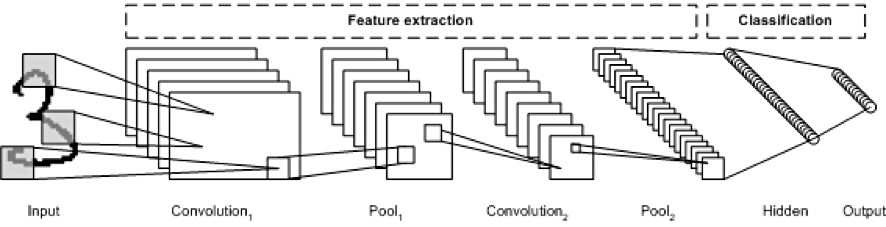

In [42]:
#Exemplo de arquitetura CNN
url = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/Images/figure06.png'
img = io.imread(url)
cv2_imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

No exemplo acima, podemos verificar que o modelo de CNN inicia-se (input) pelo número de subcamadas por canais de cores, isto é, rgb ou por escalas de cinza. Logo, nosso in_features da primera camada será 1.

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=2, stride=2, padding=0)
    self.activation = nn.ReLU()
    self.bnorm = nn.BatchNorm2d(64)
    self.pool  = nn.MaxPool2d(kernel_size=(2,2)))

    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0)
    


In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
path_train = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Training'
path_test = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Testing'

In [5]:
transform_train = transforms.Compose(
    [
     transforms.Resize([64, 64]),
     transforms.ToTensor()
    ]
)

transform_test = transforms.Compose(
    [
     transforms.Resize([64,64]),
     transforms.ToTensor()
    ]
)

In [6]:
train_dataset = datasets.ImageFolder(path_train, transform=transform_train)
test_dataset = datasets.ImageFolder(path_test, transform=transform_test)

In [13]:
print(train_dataset, '\n', test_dataset)

Dataset ImageFolder
    Number of datapoints: 2870
    Root location: /content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Training
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           ) 
 Dataset ImageFolder
    Number of datapoints: 394
    Root location: /content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Testing
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda
